In [1]:
# Imports
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='tensorflow_io')

import tqdm
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Variable settings
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>" 
training_size = 23000
num_epochs = 25

In [3]:
# Data Loading
datastore = []
with open('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json', 'r') as f:
    for line in f:
        datastore.append(json.loads(line))   

sentences = []
labels = []
urls = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [4]:
# Splitting data (sentences) and labels into training and testing sets
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [5]:
# Preprocess and vectorize text data into padded sequences
# 1. Create Tokenizer to vectorize text into integer sequences
# 2. Fit Tokenizer on training data to build vocabulary
# 3. Vectorize training and test sentences into integer sequences
# 4. Pad sequences to equal length for model input

tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

traning_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = tf.keras.preprocessing.sequence.pad_sequences(
    traning_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = tf.keras.preprocessing.sequence.pad_sequences(
    testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [6]:
# Convert data and labels to NumPy arrays to ready them for model
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [7]:
# 1D CNN with an embedding layer, a global average pooling layer, and two dense layers.
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(48, activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 16)           160000    
                                                                 
 dropout (Dropout)           (None, 100, 16)           0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 48)                816       
                                                                 
 batch_normalization (BatchN  (None, 48)               192       
 ormalization)                                                   
                                                                 
 dropout_1 (Dropout)         (None, 48)                0

In [9]:
# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min', verbose=1)
# Model Training
history = model.fit(training_padded, training_labels, epochs=num_epochs, 
                    validation_data=(testing_padded, testing_labels), 
                    callbacks=[early_stopping], verbose=2)

Epoch 1/25
719/719 - 5s - loss: 0.6001 - accuracy: 0.6658 - val_loss: 0.5155 - val_accuracy: 0.7137 - 5s/epoch - 7ms/step
Epoch 2/25
719/719 - 4s - loss: 0.4456 - accuracy: 0.7936 - val_loss: 0.3772 - val_accuracy: 0.8247 - 4s/epoch - 5ms/step
Epoch 3/25
719/719 - 3s - loss: 0.3958 - accuracy: 0.8262 - val_loss: 0.7671 - val_accuracy: 0.6588 - 3s/epoch - 5ms/step
Epoch 4/25
719/719 - 3s - loss: 0.3647 - accuracy: 0.8448 - val_loss: 0.3958 - val_accuracy: 0.8174 - 3s/epoch - 5ms/step
Epoch 5/25
719/719 - 3s - loss: 0.3448 - accuracy: 0.8521 - val_loss: 0.3883 - val_accuracy: 0.8158 - 3s/epoch - 5ms/step
Epoch 5: early stopping


176/176 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.76      0.96      0.85      2963
           1       0.93      0.66      0.77      2656

    accuracy                           0.82      5619
   macro avg       0.85      0.81      0.81      5619
weighted avg       0.84      0.82      0.81      5619



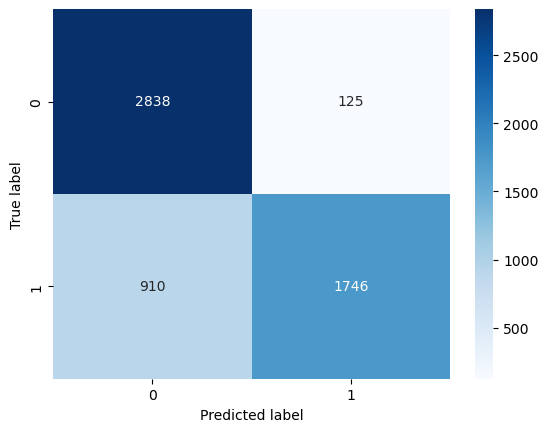

In [10]:
# Predict labels for testing data
y_pred = model.predict(testing_padded)
y_pred = (y_pred > 0.5).astype(int)

# Calculate evaluation metrics
print(classification_report(testing_labels, y_pred))

# Plot confusion matrix
cm = confusion_matrix(testing_labels, y_pred)
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [11]:
# Get embedding layer weights the model learned during training
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 16)


In [12]:
# K-Fold / Saving best performance model 
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(48, activation='elu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model1.compile(loss='binary_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

kf = KFold(n_splits=5)

best_model = None
best_accuracy = 0

pbar = tqdm.tqdm(total=5)  
for train_index, _ in kf.split(training_padded):
    # Train the model on the training fold.
    model1.fit(training_padded[train_index], training_labels[train_index], callbacks=[early_stopping], 
               epochs=num_epochs, verbose=0)
    # Evaluate the model on the test fold.
    loss, accuracy = model1.evaluate(testing_padded, testing_labels)
    print('Fold loss:', loss)
    print('Fold accuracy:', accuracy)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model1
    pbar.update(1)
pbar.close()

  0%|          | 0/5 [00:00<?, ?it/s]

176/176 [==============================] - 0s 1ms/step - loss: 0.4083 - accuracy: 0.8297


 20%|██        | 1/5 [00:58<03:52, 58.17s/it]

Fold loss: 0.4082603454589844
Fold accuracy: 0.8296849727630615
176/176 [==============================] - 0s 1ms/step - loss: 0.4294 - accuracy: 0.8199


 40%|████      | 2/5 [01:55<02:53, 57.73s/it]

Fold loss: 0.4294183850288391
Fold accuracy: 0.8198967576026917
176/176 [==============================] - 0s 2ms/step - loss: 0.4027 - accuracy: 0.8284


 60%|██████    | 3/5 [03:17<02:17, 68.95s/it]

Fold loss: 0.4026504456996918
Fold accuracy: 0.8284392356872559
176/176 [==============================] - 0s 1ms/step - loss: 0.3962 - accuracy: 0.8370


 80%|████████  | 4/5 [04:40<01:14, 74.22s/it]

Fold loss: 0.3961944282054901
Fold accuracy: 0.8369816541671753
176/176 [==============================] - 0s 2ms/step - loss: 0.4197 - accuracy: 0.8304


100%|██████████| 5/5 [06:02<00:00, 77.15s/it]

Fold loss: 0.41974595189094543
Fold accuracy: 0.8303968906402588


100%|██████████| 5/5 [06:02<00:00, 72.51s/it]


176/176 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.88      0.79      0.83      2963
           1       0.79      0.88      0.83      2656

    accuracy                           0.83      5619
   macro avg       0.83      0.83      0.83      5619
weighted avg       0.84      0.83      0.83      5619



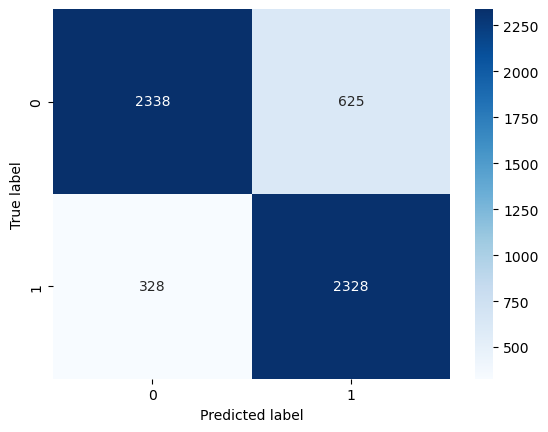

In [13]:
# Predict labels for testing data
y_pred1 = best_model.predict(testing_padded)
y_pred1 = (y_pred1 > 0.5).astype(int)

# Calculate evaluation metrics
print(classification_report(testing_labels, y_pred1))

# Plot confusion matrix
cm1 = confusion_matrix(testing_labels, y_pred1)
sns.heatmap(cm1, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

In [14]:
# Testing the models on a testing list of sentences
testing = [ "Oh great, another meeting. Just what I needed to make my day complete.", 
            "The sun rises in the east and sets in the west.",
            "It’s okay if you don’t like me. Not everyone has good taste.",
            "The weather is great today.",
            "She is studying medicine to become a doctor.",
            "Oh, fantastic! Another Monday morning. I can't wait to spend the next eight hours in my cubicle."]
sequences = tokenizer.texts_to_sequences(testing)
padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, maxlen=max_length, padding=padding_type, 
                                                       truncating=trunc_type)

In [15]:
# Predictions for 1CNN original model
model_predictions = model.predict(padded)
pct_predictions = [np.round(100*p[0], 2) for p in model_predictions]

# Percentage chance of sarcam for each sentence
print(pct_predictions)

1/1 [==============================] - 0s 22ms/step
[22.7, 0.12, 75.73, 1.53, 2.58, 33.56]


In [16]:
# Predictions for K-Fold best model
best_model_predictions = best_model.predict(padded)
pct_predictions1 = [np.round(100*p[0], 2) for p in best_model_predictions]

# Percentage chance of sarcam for each sentence
print(pct_predictions1)

1/1 [==============================] - 0s 21ms/step
[91.3, 0.26, 97.16, 6.61, 6.58, 93.05]
